In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
epsilon = 1e-5
np.seterr(divide='ignore',invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
import pydot
from IPython.display import Image, display

def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

# 5 - 决策树

In [3]:
## 给定离散的概率，求熵，e为底
def H(P):
    P = P + epsilon
    return -(np.sum(P * np.log2(P)))

In [4]:
def information_gain(X, Y):
    N, M = X.shape
    K = np.max(Y) + 1
    SX = np.max(X, axis=0) + 1
    NY = np.zeros(K)
    for i in range(K):
        NY[i] = np.count_nonzero(Y==i)
    NX = []
    for m in range(M):
        NX_i = np.zeros((SX[m],1))
        for i in range(SX[m]):
            NX_i[i,0] = np.count_nonzero(X[:, m]==i)
        NX.append(NX_i)
    HX = H(NY / N)
    NY_A = []
    for i in range(M):
        NY_Ai = np.zeros((SX[i], K))
        for j in range(SX[i]):
            t = Y[X[:, i]==j]
            for k in range(K):
                NY_Ai[j, k] = np.count_nonzero(t==k)
        NY_A.append(NY_Ai)
        
    PY_A = []
    PX = []
    for m in range(M):
        PY_A.append(NY_A[m] / NX[m]) ## NY_A[m][i, k] / NX[m][i] ## p(Y = y_k | X^m = i)
        PX.append(NX[m] / N)
    HY_X = []
    for m in range(M):
        HY_Xi = np.zeros(SX[m])
        for i in range(SX[m]):
            HY_Xi[i] = H(PY_A[m][i, :])
        HY_X.append(HY_Xi)
    HY_A = np.zeros(M)
    for m in range(M):
        HY_A[m] = np.sum(HY_X[m] * PX[m].reshape(-1)) ## numpy由于有Broadcasting存在，所以写程序的时候一定要注意维度要匹配 https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html
    HA_X = np.zeros(M)
    for m in range(M):
        HA_X[m] = H(NX[m] / N)
    gain = HX - HY_A
    return gain, gain / HA_X

In [5]:
X = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 1, 0, 1, 1],
    [0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 0, 0, 1, 0],
    [1, 1, 1, 1, 1],
    [1, 0, 1, 2, 1],
    [1, 0, 1, 2, 1],
    [2, 0, 1, 2, 1],
    [2, 0, 1, 1, 1],
    [2, 1, 0, 1, 1],
    [2, 1, 0, 2, 1],
    [2, 0, 0, 1, 0],
])
Y = X[:, -1]
Y = Y.reshape((-1,1))
X = X[:, :-1]

In [6]:
information_gain(X, Y)

(array([0.08300555, 0.32359689, 0.41990845, 0.29479317]),
 array([0.05237053, 0.35239124, 0.43247518, 0.1926588 ]))

In [7]:
class TreeNode(object):
    def __init__(self, prop=None, Nprop=None, label=None):
        self.children = dict()
        self.prop = prop
        self.Nprop = Nprop
        self.label = label
        self.leaf = False

In [8]:
def ID3(X, Y, threshold):
    N, M = X.shape
    K = np.max(Y) + 1
    SX = np.max(X, axis=0) + 1
    def build_tree(cX, cY):
        NcY = np.zeros(K)
        unique_Y = np.unique(cY)
        if len(unique_Y)==1:  ## 属于同一类
            t = TreeNode()
            t.label = unique_Y[0]
            t.leaf = True
            return t
        for i in range(K):
            NcY[i] = np.count_nonzero(cY==i)
        gain, ratio = information_gain(cX, cY)
        iP = np.argmax(gain)
        max_gain = gain[iP]
        t = TreeNode(prop=iP, Nprop=SX[iP], label = np.argmax(NcY))
        if max_gain < threshold:
            t.leaf = True
            return t
        for i in range(SX[iP]):
            cindex = (cX[:,iP] == i)
            t.children[i] = build_tree(cX[cindex], cY[cindex])
        return t
    return build_tree(X, Y)

In [9]:
root = ID3(X, Y, 0.)

In [10]:
dot = pydot.Dot()
global level
level = 1
def create_dot(p):
    global level
    p_name = "%d # %s, %s, %s" % (level, str(p.prop), str(p.Nprop), str(p.label))
    dot.add_node(pydot.Node(name=p_name))
    if p.prop == None:
        return
    for i in range(p.Nprop):
        level = level + 1
        c = p.children[i]
        c_name = "%d # %s, %s, %s" % (level, str(c.prop), str(c.Nprop), str(c.label))
        dot.add_edge(pydot.Edge(dst=c_name, src=p_name))
        create_dot(c)
        level = level -1

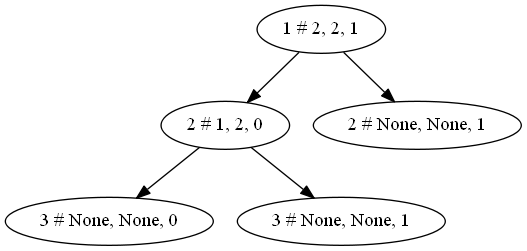

In [11]:
create_dot(root)
viewPydot(dot)

## 剪枝

前序遍历计算每个节点的H，后续遍历对有叶节点进行剪枝

In [12]:
class TreeNode(object):
    def __init__(self, prop=None, Nprop=None, label=None):
        self.children = dict()
        self.prop = prop
        self.Nprop = Nprop
        self.label = label
        self.leaf = False
        self.H = None
        
def ID3(X, Y, threshold):
    N, M = X.shape
    K = np.max(Y) + 1
    SX = np.max(X, axis=0) + 1
    global visited
    visited = np.zeros(M, dtype=np.bool)
    def build_tree(cX, cY):
        global visited
        NcY = np.zeros(K)
        unique_Y = np.unique(cY)
        if len(unique_Y)==1:  ## 属于同一类
            t = TreeNode()
            t.label = unique_Y[0]
            t.leaf = True
            t.H = 0.
            return t
        for i in range(K):
            NcY[i] = np.count_nonzero(cY==i)
        gain, ratio = information_gain(cX, cY)
        gain[visited] = - np.inf
        iP = np.argmax(gain)
        if len(np.unique(cX[:,iP]))==1:
            t1 = TreeNode(prop=None, Nprop=None, label=np.argmax(NcY))
            t1.H = H(NcY / len(cY))
            t1.leaf = True
            return t1
        max_gain = gain[iP]
        t = TreeNode(prop=iP, Nprop=SX[iP], label = np.argmax(NcY))
        t.H = H(NcY / len(cY))
        if max_gain < threshold:
            t.leaf = True
            return t
        visited[iP] = True
        for i in range(SX[iP]):
            cindex = (cX[:,iP] == i)
            t.children[i] = build_tree(cX[cindex], cY[cindex])
        visited[iP] = False
        return t
    return build_tree(X, Y)

In [13]:
root = ID3(X, Y, 0.)

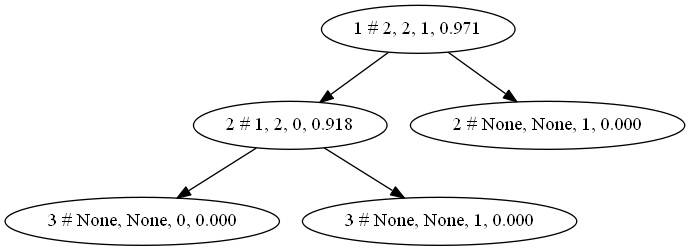

In [14]:
dot = pydot.Dot()
global level
level = 1
def create_dot(p):
    global level
    p_name = "%d # %s, %s, %s, %.3f" % (level, str(p.prop), str(p.Nprop), str(p.label), p.H)
    dot.add_node(pydot.Node(name=p_name))
    if p.leaf is True:
        return
    for i in range(p.Nprop):
        level = level + 1
        c = p.children[i]
        c_name = "%d # %s, %s, %s, %.3f" % (level, str(c.prop), str(c.Nprop), str(c.label), c.H)
        dot.add_edge(pydot.Edge(dst=c_name, src=p_name))
        create_dot(c)
        level = level -1

create_dot(root)
viewPydot(dot)

In [15]:
Watermelon = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [2, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 1, 0],
    [1, 1, 0, 1, 1, 1, 0],
    [1, 1, 0, 0, 1, 0, 0],
    [1, 1, 1, 1, 1, 0, 1],
    [0, 2, 2, 0, 2, 1, 1],
    [2, 2, 2, 2, 2, 0, 1],
    [2, 0, 0, 2, 2, 1, 1],
    [0, 1, 0, 1, 0, 0, 1],
    [2, 1, 1, 1, 0, 0, 1],
    [1, 1, 0, 0, 1, 1, 1],
    [2, 0, 0, 2, 2, 0, 1],
    [0, 0, 1, 1, 1, 0, 1],
])
Y = Watermelon[:, -1]
Y = Y.reshape((-1,1))
X = Watermelon[:, :-1]

In [16]:
root = ID3(X, Y, 0.)

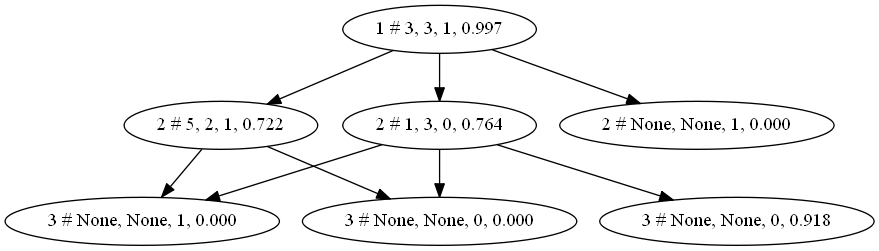

In [17]:
dot = pydot.Dot()
create_dot(root)
viewPydot(dot)

不是leaf并且子节点的leaf==true

In [18]:
def pruning(root, threshold):
    if root.leaf is True:
        return;
    print(root.H, root.leaf)
    for p in root.children.values():
        pruning(p, threshold)
    if root.children[0].leaf is True:
        t = 0.
        l = len(root.children)
        for p in root.children.values():
            t = t + p.H
        if t - root.H < (l-1) * threshold:
            for i in range(l):
                root.children[i] = None
                root.leaf = True

In [19]:
pruning(root, .0)

0.9974937421855691 False
0.764200977141265 False
0.7219256790976065 False


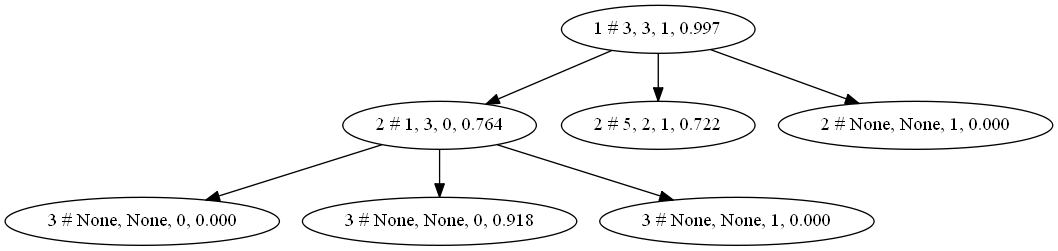

In [20]:
dot = pydot.Dot()
create_dot(root)
viewPydot(dot)

----

## CART
需要在当前节点对应的数据集下计算所有属性和属性值对应的Gini指数，对最大Gini指数的进行划分，小于阈值跳出

In [21]:
class TreeNode(object):
    def __init__(self, prop, value, label):
        self.prop = prop
        self.value = value
        self.label = label
        self.lc = None
        self.rc = None
        self.leaf = False
        self.N_leaf = 0
        self.H = 0.
        self.g = 0.

In [22]:
def CART_C(X, Y, threshold, purning_thre):
    N, M = X.shape
    SX = np.max(X, axis=0) + 1
    K = np.max(Y) + 1
    global visited
    visited = []
    for m in range(M):
        visited.append(np.zeros(SX[m], dtype=np.bool))
    def build_tree(cX, cY):
        global visited
        PX_Y = []
        for m in range(M):
            PXi = np.zeros((SX[m], K))
            for i in range(SX[m]):
                index = (cX[:, m] == i)
                iY = cY[index]
                l = len(iY)
                for k in range(K):
                    PXi[i, k] = len(np.where(iY==k)[0]) / (l+epsilon)
                    if l == 0:
                        PXi[i, k] = 1
            PX_Y.append(PXi)
        ginis = []
        mginis = np.zeros(M)
        mindex = np.zeros(M, dtype=np.int)
        for m in range(M):
            PXi = PX_Y[m]
            gs = 1 - np.sum(np.power(PXi, 2), axis=1)
            gs[visited[m]] = -np.inf
            mm = np.argmax(gs)
            mindex[m] = mm
            mginis[m] = gs[mm]
        mpi = np.argmax(mginis)
        mpii = mindex[mpi]
        mmg = mginis[mpi]
        t = TreeNode(prop=mpi, value=mpii, label=np.argmax(PX_Y[mpi][mpii,:]))
        t.H = H(PX_Y[mpi][mpii,:])
        if mmg <= (threshold+epsilon):
            t.leaf = True
            t.N_leaf = 1
            t.g = 0.
            return t
        t.leaf = False
        visited[mpi][mpii] = True
        index = (cX[:, mpi] == mpii)
        t.lc = build_tree(cX[index], cY[index])
        t.rc = build_tree(cX[np.logical_not(index)], cY[np.logical_not(index)])
        t.N_leaf = t.lc.N_leaf + t.rc.N_leaf
        visited[mpi][mpii] = False
        return t
    root = build_tree(X, Y)
    return root

In [23]:
root = CART_C(X, Y, 0.45, 0.1)

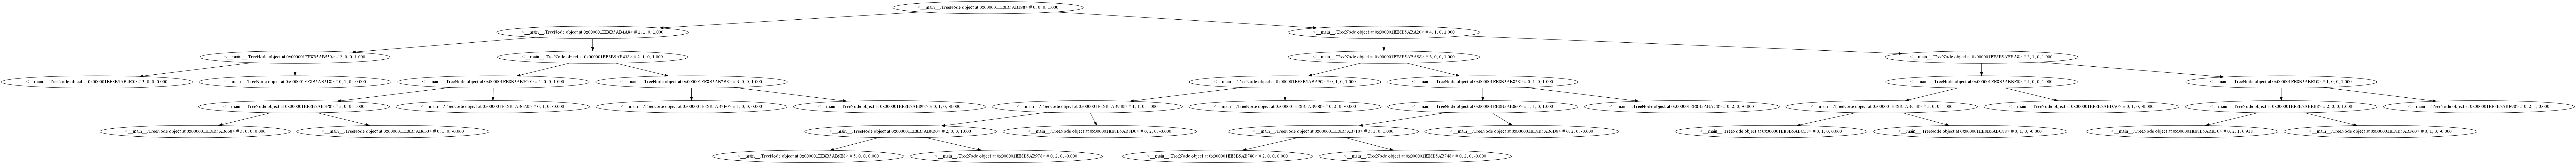

In [24]:
dot = pydot.Dot()
global level
level = 1
def create_dot(p):
    global level
    p_name = "%s # %s, %s, %s, %.3f" % (p.__str__(), str(p.prop), str(p.value), str(p.label), p.H)
    dot.add_node(pydot.Node(name=p_name))
    if p.leaf is True:
        return
    for c in [p.lc, p.rc]:
        level = level + 1
        c_name = "%s # %s, %s, %s, %.3f" % (c.__str__(), str(c.prop), str(c.value), str(c.label), c.H)
        dot.add_edge(pydot.Edge(dst=c_name, src=p_name))
        create_dot(c)
        level = level -1

create_dot(root)
viewPydot(dot)